In [90]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as systime
import datetime as dtime
import string
import seaborn as sns
%pylab inline

from IPython.core.display import HTML
def css_styling():
    styles = open("style.css", "r").read()
    return HTML(styles)
css_styling()

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# functions
def splitDatetime(data): #function for splitting the timestamp
    sub = pd.DataFrame(data.Dates.str.split(' ').tolist(), columns = "date time".split())
    date = pd.DataFrame(sub.date.str.split('-').tolist(), columns="year month day".split())
    time = pd.DataFrame(sub.time.str.split(':').tolist(), columns = "hour minute second".split())
    data['year'] = date['year'].astype(int)
    data['month'] = date['month'].astype(int)
    data['day'] = date['day'].astype(int)
    data['hour'] = time['hour'].astype(int)
    # translating into weekday is not needed because that information is already in the data
    #data['weekday']=0 #weekday=0: monday, weekday=6: sunday.
    #for i in range(0,len(train.year)):
    #    data.weekday[i]=dtime.date(train.year[i], train.month[i], train.day[i]).weekday()   
    return data

In [3]:
# read in the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = splitDatetime(train)
test = splitDatetime(test)

In [4]:
# this is a map, mapping day of week to a number:
dow = {
    'Monday':0,
    'Tuesday':1,
    'Wednesday':2,
    'Thursday':3,
    'Friday':4,
    'Saturday':5,
    'Sunday':6
}

# this is the inverse map:
wod = {v: k for k, v in dow.items()}

# map for categories->numbers
catnum = {
'WARRANTS':0, 'OTHER OFFENSES':1, 'LARCENY/THEFT':2, 'VEHICLE THEFT':3, 'VANDALISM':4,
 'NON-CRIMINAL':5, 'ROBBERY':6, 'ASSAULT':7, 'WEAPON LAWS':8, 'BURGLARY':9,
 'SUSPICIOUS OCC':10, 'DRUNKENNESS':11, 'FORGERY/COUNTERFEITING':12, 'DRUG/NARCOTIC':13,
 'STOLEN PROPERTY':14, 'SECONDARY CODES':15, 'TRESPASS':16, 'MISSING PERSON':17, 'FRAUD':18,
 'KIDNAPPING':19, 'RUNAWAY':20, 'DRIVING UNDER THE INFLUENCE':21,
 'SEX OFFENSES FORCIBLE':22, 'PROSTITUTION':23, 'DISORDERLY CONDUCT':24, 'ARSON':25,
 'FAMILY OFFENSES':26, 'LIQUOR LAWS':27, 'BRIBERY':28, 'EMBEZZLEMENT':29, 'SUICIDE':30,
 'LOITERING':31, 'SEX OFFENSES NON FORCIBLE':32, 'EXTORTION':33, 'GAMBLING':34,
 'BAD CHECKS':35, 'TREA':36, 'RECOVERED VEHICLE':37, 'PORNOGRAPHY/OBSCENE MAT':38
}
muntac={v:k for k,v in catnum.items()}

train['DOW'] = train.DayOfWeek.map(dow)
test['DOW'] = test.DayOfWeek.map(dow)
train['catnum']=train.Category.map(catnum)

In [85]:
train.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,month,day,hour,DOW,event,catnum
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,2,1,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,2,1,1
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,2,1,1
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,2,1,2
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,2,1,2


In [8]:
# list all possible categories - that's the target variable
Ncat=len(pd.unique(train.Category.ravel()))
print "all "+str(Ncat)+" categories:"
print pd.unique(train.Category.ravel())
print '----'
Nyears=len(pd.unique(train.year.ravel()))
print "all "+str(Nyears)+" years:"
print pd.unique(train.year.ravel())
print '----'
Ndist=len(pd.unique(train.PdDistrict.ravel()))
print "all "+str(Ndist)+" districts:"
print pd.unique(train.PdDistrict.ravel())

all 39 categories:
['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']
----
all 13 years:
[2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003]
----
all 10 districts:
['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']


/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


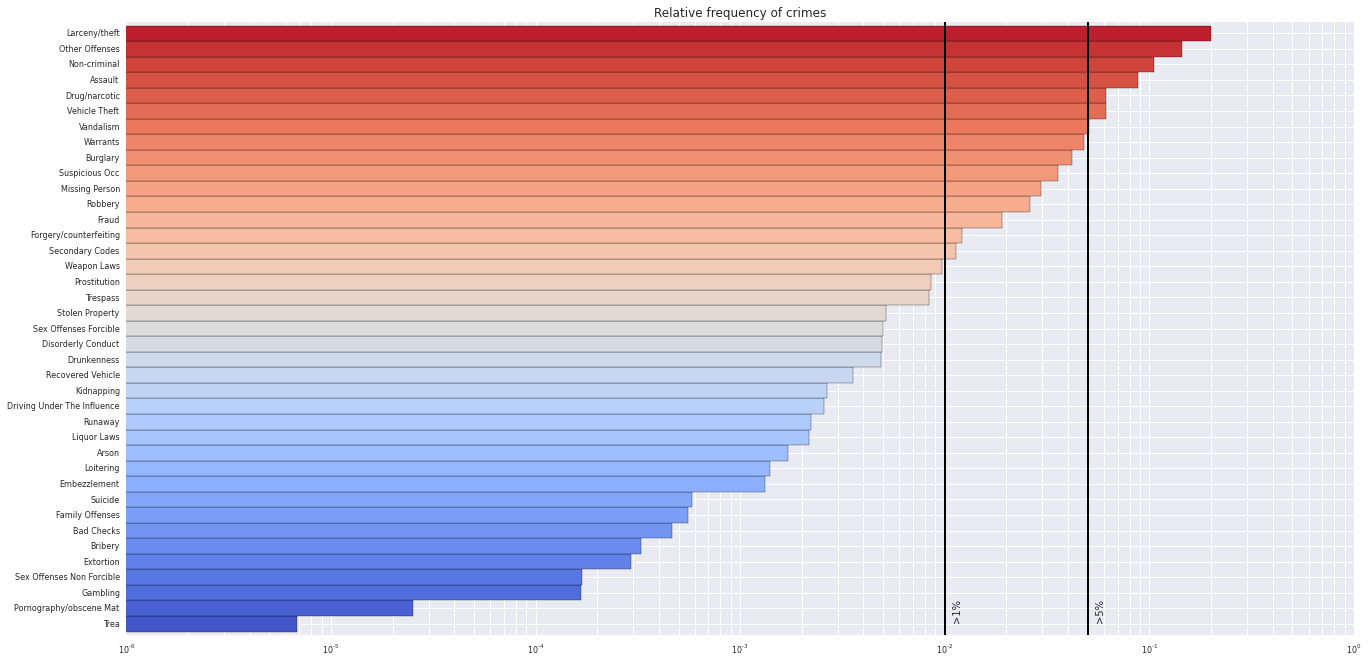

In [138]:
# what are the most recored crimes?

column='Category'
by_col = train.groupby(column)
cf = by_col.size()
cf.index = cf.index.map(string.capwords)
cf.sort(ascending=True, inplace=True)
Ntot=sum(cf)
cf/=Ntot

figure(figsize=(22,11),dpi=500)
cf.plot(kind='barh',
        title='Relative frequency of crimes',
        fontsize=8,
        stacked=False,
        width=1,
        color=sns.color_palette('coolwarm', Ncat)
        )
#grid()
xscale('log',nonposx='clip')
plt.axvline(x=0.05, ymin=0.0, ymax = 1, linewidth=2, color='k')
plt.text(0.055,1,'>5%',rotation=90)
plt.axvline(x=0.01, ymin=0.0, ymax = 1, linewidth=2, color='k')
plt.text(0.011,1,'>1%',rotation=90)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


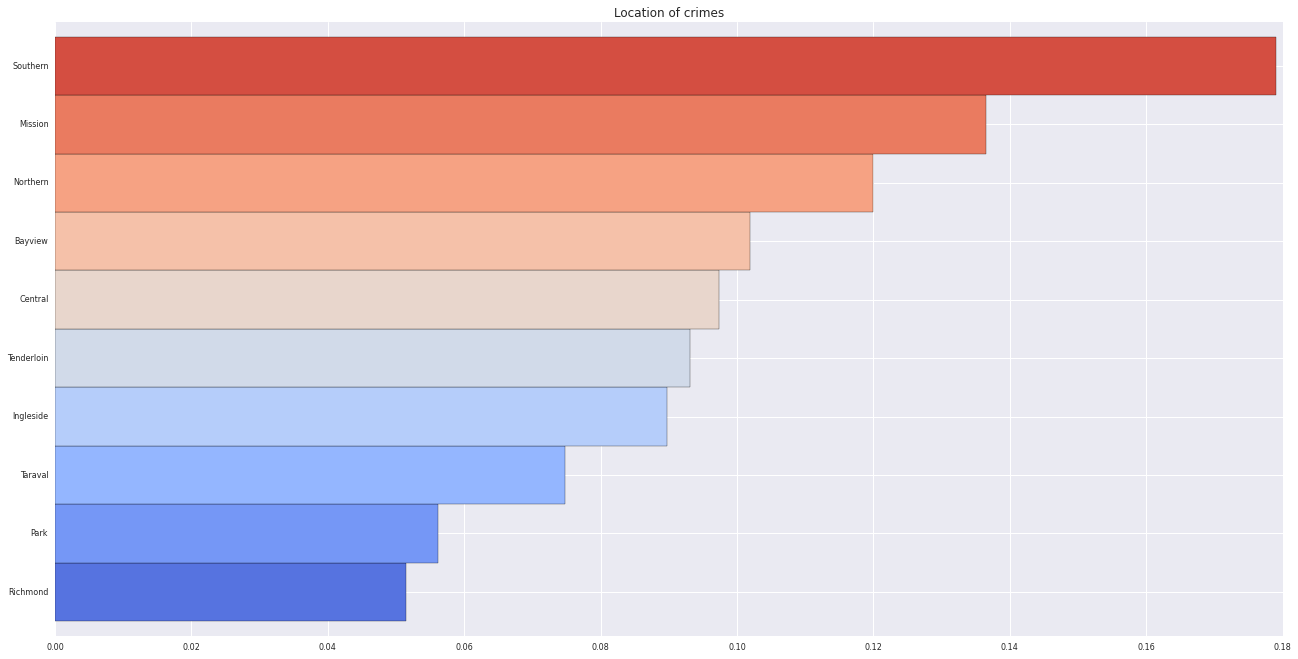

In [139]:
# where are the most crimes reported?
# 18% of crimes in Southern, 5% of crimes in Richmond

column='PdDistrict'
by_col = train.groupby(column)
cf = by_col.size()
cf.index = cf.index.map(string.capwords)
cf.sort(ascending=True, inplace=True)
Ntot=sum(cf)
cf/=Ntot

cf.plot(kind='barh',
        title='Location of crimes',
        fontsize=8,
        figsize=(22,11),
        stacked=False,
        width=1,
        color=sns.color_palette('coolwarm', Ndist)
        )
#xscale('log',nonposx='clip')
#grid()

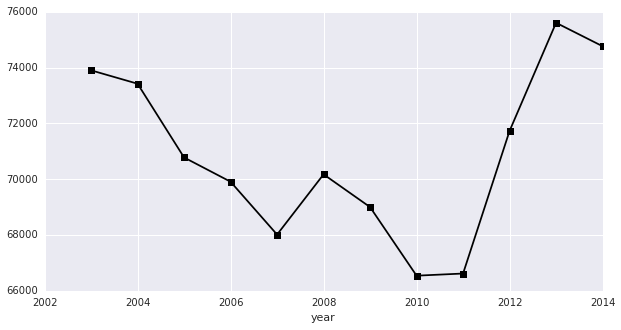

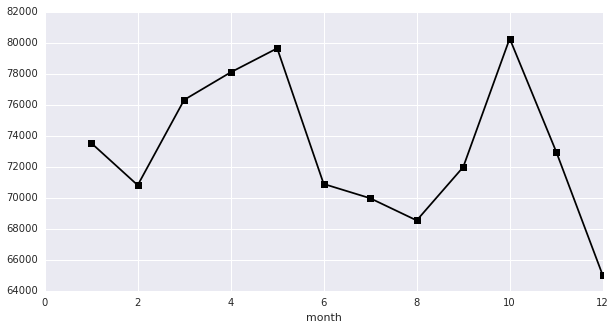

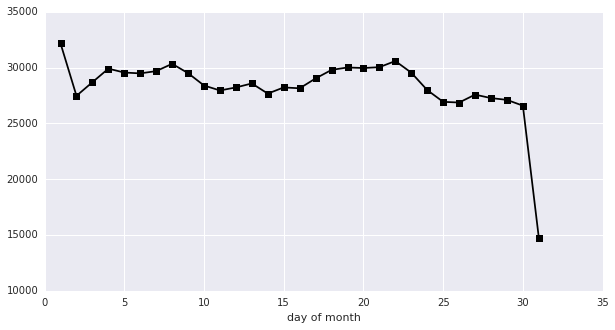

In [140]:
# number of crimes by year
# skip 2015 because lack of data

column='year'
by_col = train.groupby(column)
cf = by_col.size()
figure(figsize=(10,5))
plot(cf.index[:Nyears-1],cf[:Nyears-1], 'ks-')
xlabel('year')

# number of crimes by month
# most crimes in May and October; December more safe?

column='month'
by_col = train.groupby(column)
cf = by_col.size()
figure(figsize=(10,5))
plot(cf.index,cf, 'ks-')
xlabel('month')

column='day'
by_col = train.groupby(column)
cf = by_col.size()
figure(figsize=(10,5))
plot(cf.index,cf, 'ks-')
xlabel('day of month')

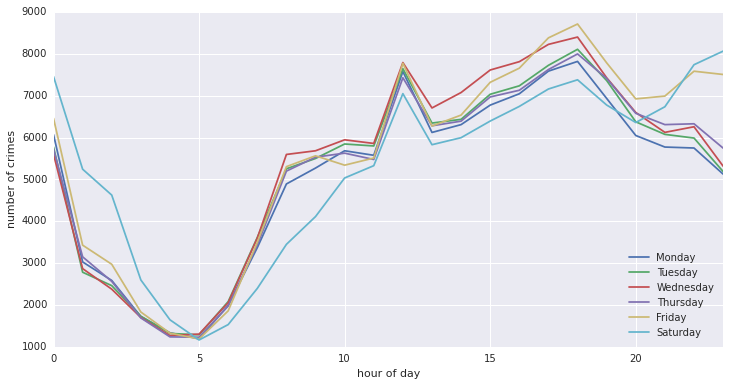

In [135]:
# plot the number of crimes vs time of day

figure(figsize=(12,6))
train['event']=1
for i in range(0,6):
    tt=train[train.DOW==i]
    hourly_events = tt[['hour','event']].groupby(['hour']).count().reset_index()
    plot(hourly_events.hour,hourly_events.event,label=wod[i])
    
legend(loc=4)
xlim(0,23);
ylabel("number of crimes")
xlabel("hour of day")

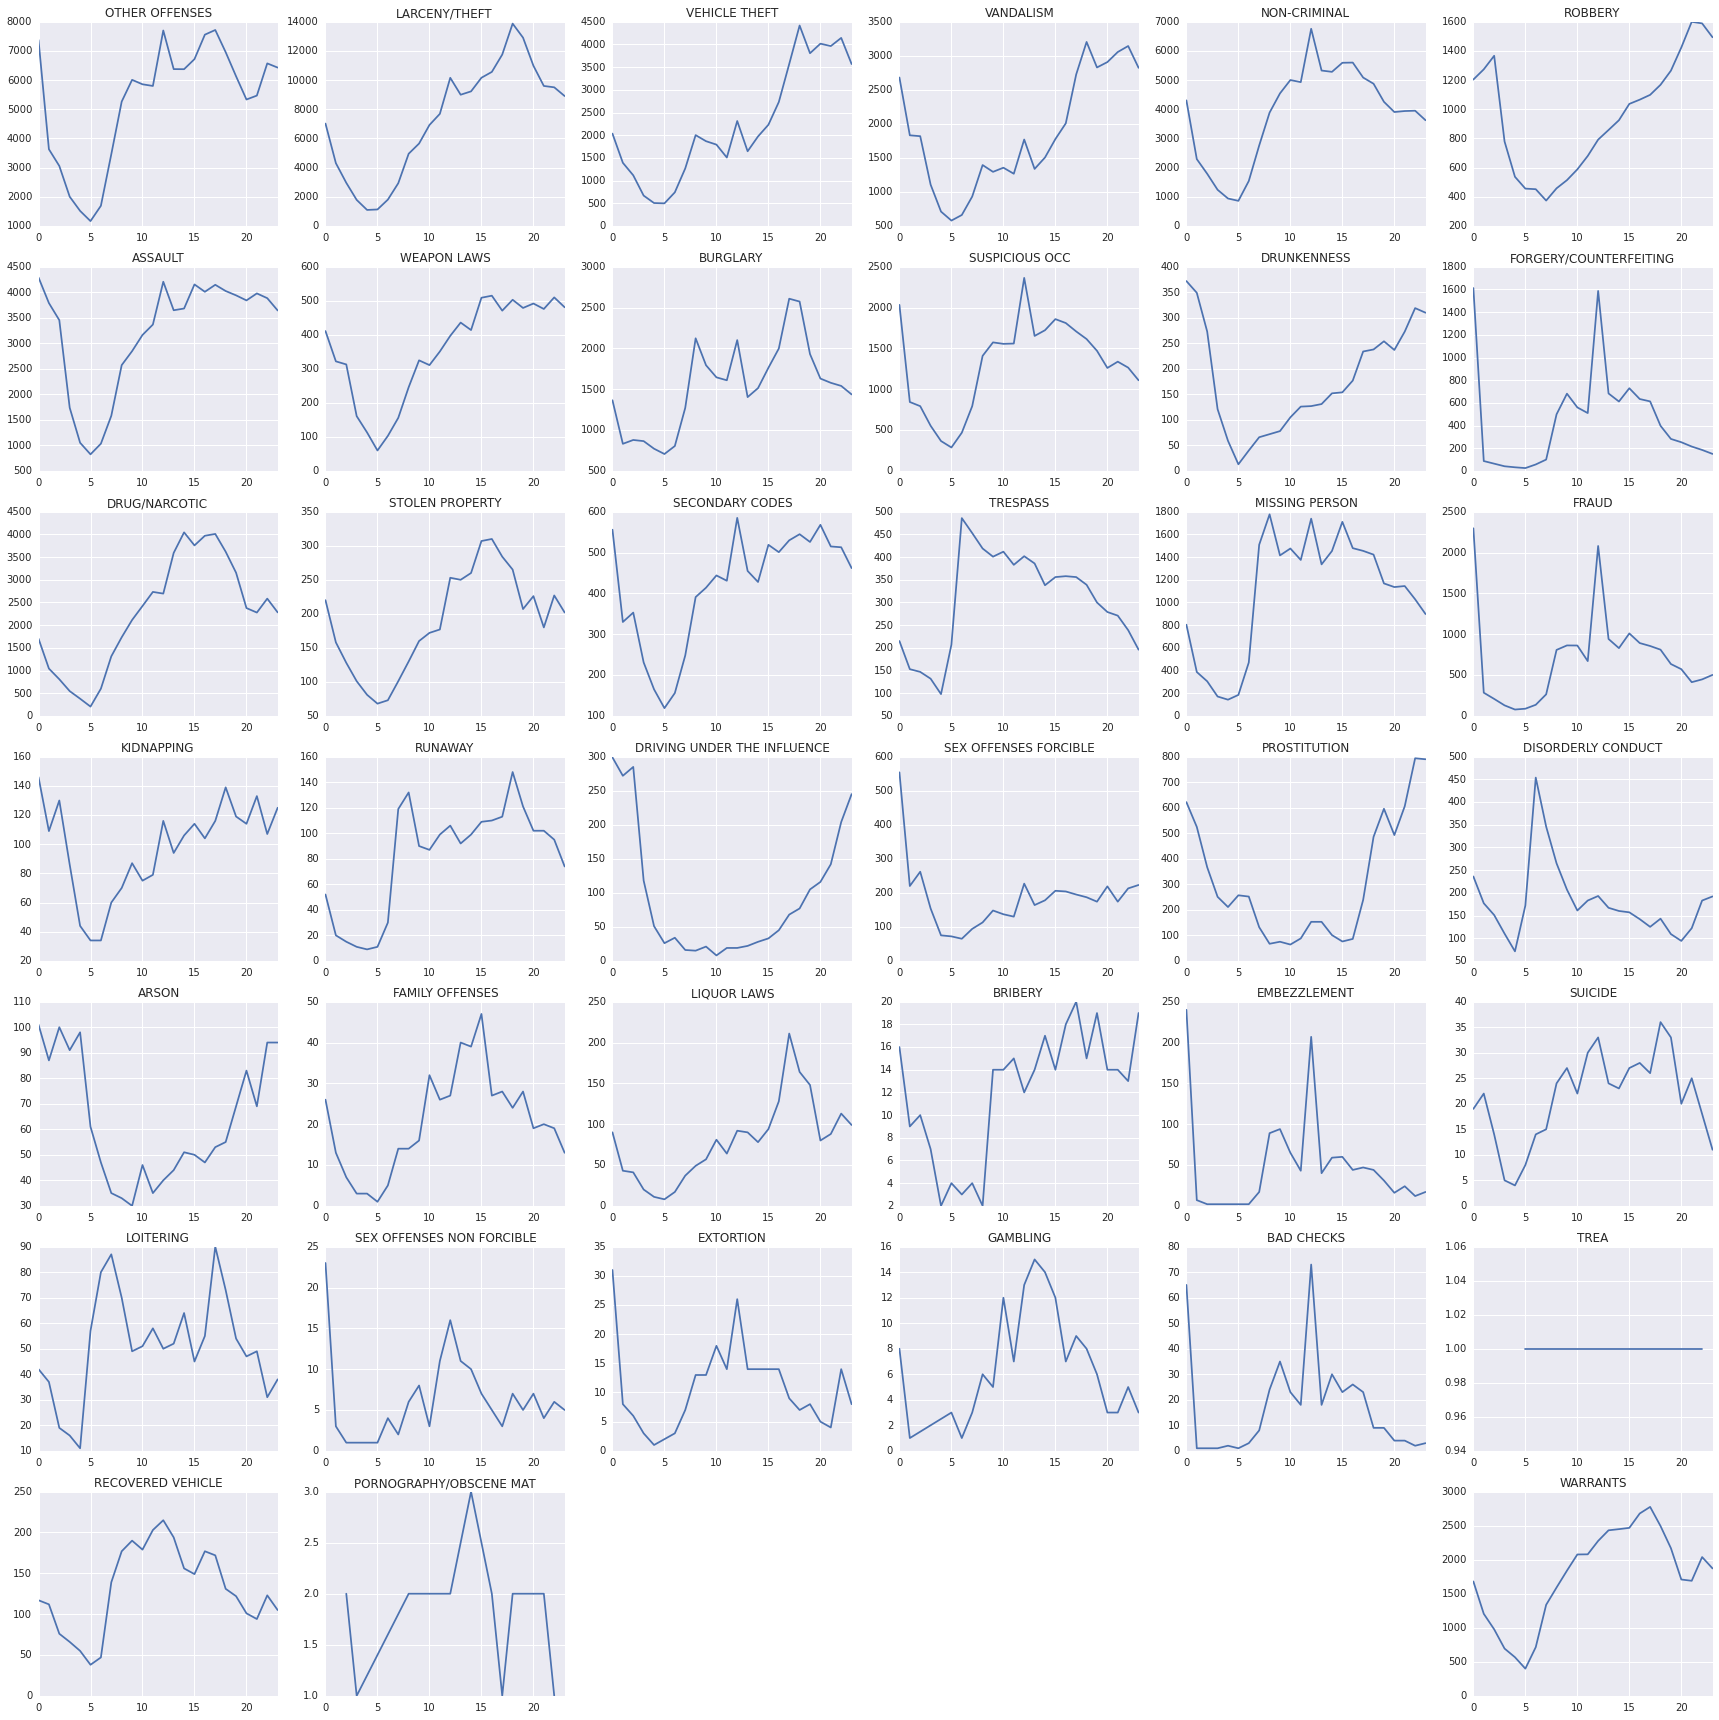

In [136]:
# plot the number of crimes vs time of day for individual crimes

figure(figsize=(30,30))
train['event']=1
for i in range(0,39):
    subplot(7,6,i)
    tt=train[train.catnum==i]
    hourly_events = tt[['hour','event']].groupby(['hour']).count().reset_index()
    plot(hourly_events.hour,hourly_events.event,label=muntac[i])
    #grid()
    #legend(loc=4)
    title(muntac[i])
    xlim(0,23);
#ylabel("number of crimes")
#xlabel("hour of day")